In [ ]:
from gGA.utils.wannier import get_wannier_blocks
import h5py
import os
from ase.io import read
import numpy as np
from gGA.data import AtomicData, AtomicDataDict, OrbitalMapper
from gGA.data.interfaces import block_to_feature
from gGA.gutz.hr2hk import GGAHR2HK
from gGA.utils.make_kpoints import abacus_kpath
import os

blocks = get_wannier_blocks(
    atomic_symbol=["Eu", "O"],
    file="./gGA/test/EuO_hr.dat",
    target_basis_order={"Eu": ["d", "f"], "O": ["p"]},
    wannier_proj_orbital={"Eu": ["f", "d"], "O": ["p"]},
    orb_wan={"p": ["px", "py", "pz"], "d": ["dxy", "dyz", "dxz", "dx2-y2", "dz2"], "f":['fz3', 'fxz2', 'fyz2', 'fxyz', 'fx3-3xy2','f3x2y-y3','fx2z-y2z']}
)


data = AtomicData.from_ase(
    atoms=read("./gGA/test/EuO.vasp"),
    r_max={"Eu": 5.5, "O": 5.5},
    pbc=True
)

atoms = data.to_ase()

idp = OrbitalMapper(basis={"Eu": "1d1f", "O":"1p"}, spin_deg=True)
hr2k = GGAHR2HK(idp_phy=idp)

kpoints, xx, _ = abacus_kpath(
    atoms,
    kpath=np.array([
        [0.0000000000,   0.0000000000,   0.0000000000,     20],
        [0.5000000000,   0.0000000000,   0.5000000000,     20],                         
        [0.6250000000,   0.2500000000,   0.6250000000,     1], 
        [0.3750000000,   0.3750000000,   0.7500000000,     20],
        [0.0000000000,   0.0000000000,   0.0000000000,     20],
        [0.5000000000,   0.5000000000,   0.5000000000,     20],
        [0.5000000000,   0.2500000000,   0.7500000000,     20],
        [0.5000000000,   0.0000000000,   0.5000000000,     1],
    ]
    )
)


['0-fz3', '0-fxz2', '0-fyz2', '0-fxyz', '0-fx3-3xy2', '0-f3x2y-y3', '0-fx2z-y2z', '0-dxy', '0-dyz', '0-dxz', '0-dx2-y2', '0-dz2', '1-px', '1-py', '1-pz']
['0-dxy', '0-dyz', '0-dz2', '0-dxz', '0-dx2-y2', '0-fz3', '0-fxz2', '0-fyz2', '0-fxyz', '0-fx3-3xy2', '0-f3x2y-y3', '0-fx2z-y2z', '1-py', '1-pz', '1-px']


In [2]:
block_to_feature(data=data, idp=idp, blocks=blocks)
data = AtomicData.to_AtomicDataDict(data)
data[AtomicDataDict.KPOINT_KEY] = kpoints
data = idp(data)

In [3]:
_, ham, _ = hr2k(data)
eigval, eigvec = np.linalg.eigh(ham)

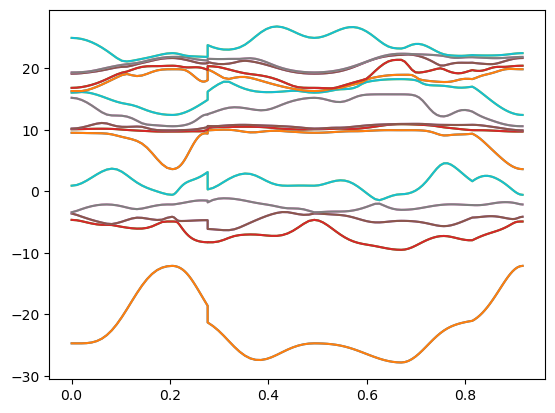

In [4]:
import matplotlib.pyplot as plt

plt.plot(xx, eigval)
# plt.ylim(-10,10)
plt.show()

In [5]:
from gGA.utils.make_kpoints import kmesh_sampling
import torch
from gGA.gutz import GhostGutzwiller

# setup_seed(1234)

torch.set_default_dtype(torch.float64)
U = 0.1
J = 0. # 0.25 * U
Up = U - 2*J
Jp = J

gga = GhostGutzwiller(
    atomic_number=np.array([63, 8]),
    nocc=17,
    basis={"Eu":"1d1f", "O":"1p"},
    idx_intorb={"Eu":[1]},
    naux=3,
    intparams={"Eu":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=1,
    kBT=0.0002,
    overlap=False,
    mutol=1e-4,
    solver="NQS",
    mixer_options={"method": "Linear", "a": 0.3},
    iscomplex=True,
    solver_options={"mfepmin":2000, "channels": 10, "Ptol": 1e-3},
)

data["kpoint"] = kmesh_sampling([10,10,10], True)

In [6]:
gga.run(data, 200, 1e-3)

DM_kin:  [9.67238434e-04 9.67238434e-04 2.34041595e-03 2.34041595e-03
 5.64345519e-03 5.64345519e-03 1.19148594e-02 1.19148594e-02
 3.80281878e-02 3.80281878e-02 4.60874030e-02 4.60874030e-02
 5.34261232e-02 5.34261232e-02 1.43876944e-01 1.43876944e-01
 1.88666924e-01 1.88666924e-01 2.67517934e-01 2.67517934e-01
 3.15787537e-01 3.15787537e-01 3.80783715e-01 3.80783715e-01
 4.17324054e-01 4.17324054e-01 4.90088971e-01 4.90088971e-01
 5.10695446e-01 5.10695446e-01 5.25408987e-01 5.25408987e-01
 7.20142092e-01 7.20142092e-01 7.39964752e-01 7.39964752e-01
 8.43482072e-01 8.43482072e-01 8.66825289e-01 8.66825289e-01
 9.64158638e-01 9.64158638e-01 9.78917028e-01 9.78917028e-01
 9.92972484e-01 9.92972484e-01 9.97806046e-01 9.97806046e-01
 9.98552754e-01 9.98552754e-01 9.99094817e-01 9.99094817e-01
 9.99714638e-01 9.99714638e-01 9.99865874e-01 9.99865874e-01
 9.99977870e-01 9.99977870e-01]


Meanfield Pfaffian training:   1%|          | 51/5000 [13:46<22:17:08, 16.21s/it]


KeyboardInterrupt: 